In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
conn = sqlite3.connect("flights.sqlite")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('airports',), ('airlines',), ('cities',), ('ny_flights',)]


In [3]:
## matplotlib settings
axis_font = {'fontname':'Arial', 'size':'20'}
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## Preview tables using pandas
### Convert sql database, use pandas to preview

### Seems like Nan are either due to canclled or diverted
look for Nan when those are removed

## Cleaning
## Look for na values in columns

## Look for outliers in summary with boxplot

## Discard outliers?

In [4]:
def read_tables_to_df(table_name):
    df = pd.read_sql_query("select * from {}".format(table_name), conn)
    return df

In [8]:
cursor.execute("PRAGMA table_info('ny_flights');")
print(cursor.fetchall())

[(0, 'fl_date', 'TEXT', 0, None, 0), (1, 'op_carrier_airline_id', 'REAL', 0, None, 0), (2, 'op_carrier_fl_num', 'REAL', 0, None, 0), (3, 'origin_airport_id', 'REAL', 0, None, 0), (4, 'origin_city_market_id', 'REAL', 0, None, 0), (5, 'dest_airport_id', 'REAL', 0, None, 0), (6, 'dest_city_market_id', 'REAL', 0, None, 0), (7, 'crs_dep_time', 'TEXT', 0, None, 0), (8, 'dep_time', 'TEXT', 0, None, 0), (9, 'dep_delay', 'REAL', 0, None, 0), (10, 'taxi_out', 'REAL', 0, None, 0), (11, 'wheels_off', 'TEXT', 0, None, 0), (12, 'wheels_on', 'TEXT', 0, None, 0), (13, 'taxi_in', 'REAL', 0, None, 0), (14, 'crs_arr_time', 'TEXT', 0, None, 0), (15, 'arr_time', 'TEXT', 0, None, 0), (16, 'arr_delay', 'REAL', 0, None, 0), (17, 'cancelled', 'INTEGER', 0, None, 0), (18, 'diverted', 'INTEGER', 0, None, 0), (19, 'crs_elapsed_time', 'REAL', 0, None, 0), (20, 'actual_elapsed_time', 'REAL', 0, None, 0), (21, 'air_time', 'REAL', 0, None, 0), (22, 'distance', 'REAL', 0, None, 0)]


In [9]:
df_nyflights = read_tables_to_df("ny_flights")
df_nyflights.head(5)

,fl_date,op_carrier_airline_id,op_carrier_fl_num,origin_airport_id,origin_city_market_id,dest_airport_id,dest_city_market_id,crs_dep_time,dep_time,dep_delay,...,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance
0,2018-06-11,20436.0,448.0,10792.0,30792.0,13204.0,31454.0,1459,None,NaN,...,NaN,1740,None,NaN,1,0,161.0,NaN,NaN,1011.0
1,2018-06-11,20436.0,459.0,12391.0,31703.0,13487.0,31650.0,0545,0538,-7.0,...,14.0,0756,0734,-22.0,0,0,191.0,176.0,151.0,1057.0
2,2018-06-11,20436.0,506.0,11292.0,30325.0,12953.0,31703.0,1107,1103,-4.0,...,12.0,1700,1642,-18.0,0,0,233.0,219.0,194.0,1620.0
3,2018-06-11,20436.0,423.0,12953.0,31703.0,10397.0,30397.0,1750,1740,-10.0,...,39.0,2033,2116,43.0,0,0,163.0,216.0,110.0,762.0
4,2018-06-11,20436.0,1249.0,14843.0,34819.0,12391.0,31703.0,0239,0233,-6.0,...,6.0,0655,0646,-9.0,0,0,256.0,253.0,236.0,1597.0


## Bit of cleaning

In [10]:
missing_df = df_nyflights.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing value count']
missing_df['data fill (%)']=(df_nyflights.shape[0]-missing_df['missing value count'])/df_nyflights.shape[0]*100
missing_df.sort_values('data fill (%)').reset_index(drop = True)

,variable,missing value count,data fill (%)
0,arr_delay,24240,97.063288
1,actual_elapsed_time,23818,97.114414
2,air_time,23818,97.114414
3,wheels_on,21465,97.399484
4,taxi_in,21465,97.399484
5,arr_time,21464,97.399605
6,wheels_off,20952,97.461634
7,taxi_out,20952,97.461634
8,dep_delay,20850,97.473992
9,dep_time,19854,97.594659


### Since there is a pretty good amount of data > 97% to work with, we'll simply drop all rows with missing values

In [11]:
df_nyflights.dropna(inplace=True)

# Part 1: Exploring a route

Choose a route between two airports that you're interested in, for example JFK to Los Angeles Int'l, or LaGuardia to O'Hare. Do a brief exploratory analysis of this route using graphs to vizualize the data when you can. You don't need to examine every possible variable or relationship; a handful of interesting ones is fine.

Some example questions you might investigate:

- How busy is this route? Are there more flights on some days than others?
- Which airlines provide the most flights on this route?
- What do delays on this route look like?
- Are there strange-looking days on this route with fewer-than-normal flights or longer-than-normal delays?

... or anything you might be curious about.

In [12]:
def search_airport_id(State):
    cursor.execute('SELECT * FROM airports WHERE airports.location LIKE "{}"'.format(State)) 
    print(cursor.fetchall())

In [13]:
## get NY airport ID
search_airport_id("%New York, NY")

[(11703.0, 'New York, NY', 'Flushing'), (12478.0, 'New York, NY', 'John F. Kennedy International'), (12541.0, 'New York, NY', 'Pan Am Building Heliport'), (12545.0, 'New York, NY', 'West 30th Street Heliport'), (12546.0, 'New York, NY', 'Downtown Manhattan/Wall Street Heliport'), (12548.0, 'New York, NY', 'East 60th Street Heliport'), (12953.0, 'New York, NY', 'LaGuardia'), (13784.0, 'New York, NY', 'New York City Metropolitan Area'), (15346.0, 'New York, NY', 'East 34th Street Heliport'), (15859.0, 'New York, NY', 'World Trade Center Heliport'), (16832.0, 'New York, NY', 'New York Skyports Seaplane Base')]


### from this search I decided to use John F. Kenndy International as the origin which has an id=12478

In [14]:
# get SFO airport ID
search_airport_id("%San Francisco, CA") 

[(12457.0, 'San Francisco, CA', 'China Basin Heliport'), (12515.0, 'San Francisco, CA', 'Marin County Heliport'), (14771.0, 'San Francisco, CA', 'San Francisco International')]


### from this search I decided to use San Francisco International as the destination which has an id=14771, which should have a lot of routes from JFK

## Get a database of flights between JFK and SFO

In [115]:
query = '''SELECT ny_flights.*, airlines.airline_name from ny_flights 
    JOIN airlines
    ON ny_flights.op_carrier_airline_id = airlines.id
    WHERE origin_airport_id=12478 AND dest_airport_id=14771'''

df_NY_SF = pd.read_sql_query(query, conn)

df_NY_SF = df_NY_SF.loc[:,['fl_date', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'airline_name']]
df_NY_SF.head(5)

,fl_date,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,airline_name
0,2018-06-25,0730,0723,-7.0,28.0,0751,1027,5.0,1056,1032,-24.0,0,0,386.0,369.0,336.0,2586.0,Alaska Airlines Inc.
1,2018-06-25,0930,1044,74.0,26.0,1110,1345,16.0,1256,1401,65.0,0,0,386.0,377.0,335.0,2586.0,Alaska Airlines Inc.
2,2018-06-25,1130,1215,45.0,30.0,1245,1513,6.0,1457,1519,22.0,0,0,387.0,364.0,328.0,2586.0,Alaska Airlines Inc.
3,2018-06-25,1656,1651,-5.0,73.0,1804,2050,6.0,2041,2056,15.0,0,0,405.0,425.0,346.0,2586.0,Alaska Airlines Inc.
4,2018-06-25,1855,1907,12.0,34.0,1941,2214,5.0,2240,2219,-21.0,0,0,405.0,372.0,333.0,2586.0,Alaska Airlines Inc.


## Flights on the JFK to SFO route

In [116]:
df_NY_SF.sort_values(by='fl_date')
df_NY_SF_day = df_NY_SF.groupby('fl_date').count()

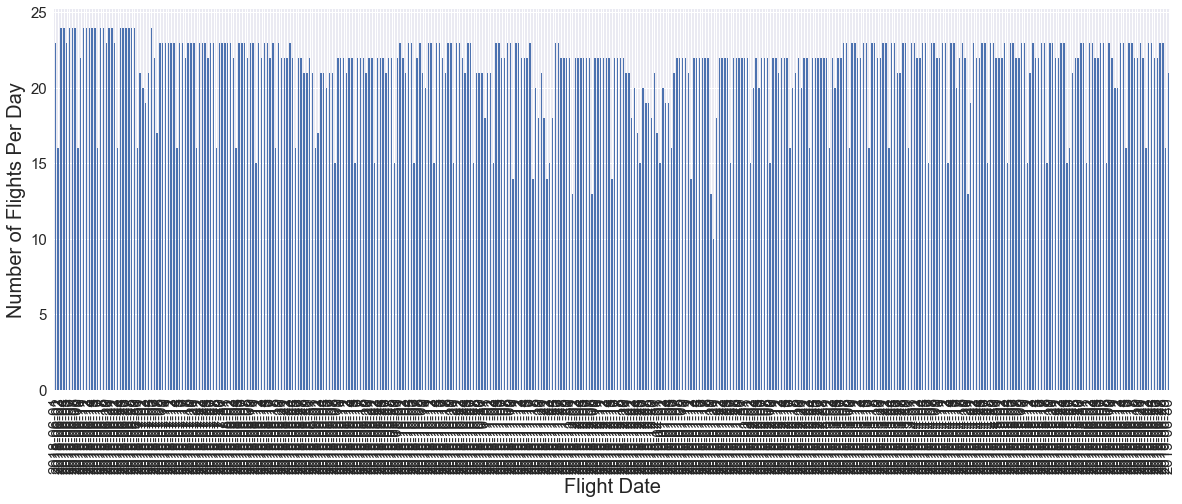

In [117]:
df_NY_SF_day['dep_delay'].plot.bar(figsize=(20,7))
plt.xlabel('Flight Date', **axis_font)
plt.ylabel('Number of Flights Per Day', **axis_font)
plt.show()

### This chart is too granular, so lets look at the information by Month

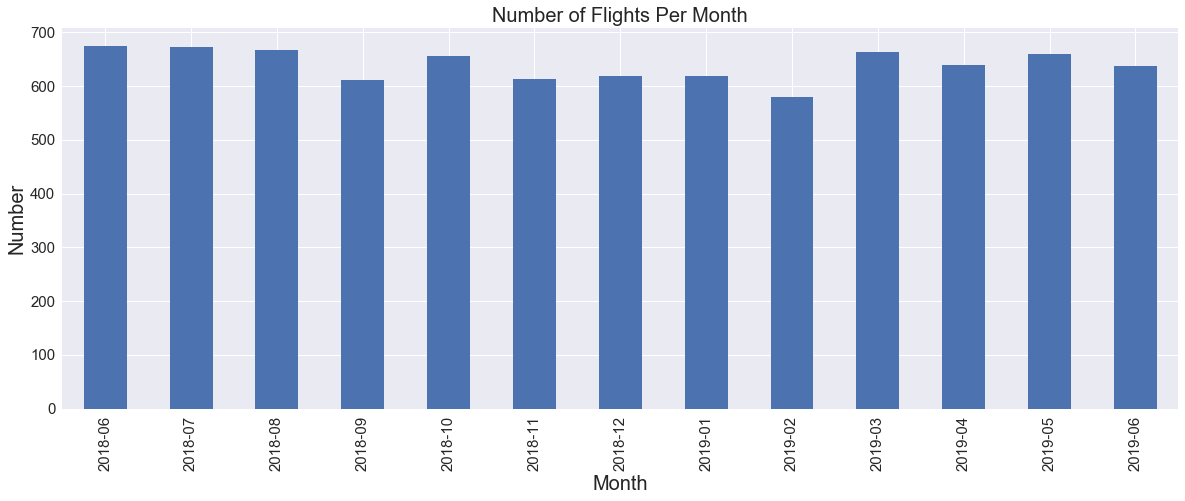

In [118]:
df_NY_SF['MONTH'] = pd.DatetimeIndex(df_NY_SF['fl_date']).to_period('M')
df_NY_SF['DAY'] = pd.DatetimeIndex(df_NY_SF['fl_date']).to_period('D')
month_table = df_NY_SF['dep_delay'].groupby(df_NY_SF['MONTH']).count()
df_NY_SF['Days_in_Month'] = df_NY_SF['MONTH'].dt.daysinmonth
#avg_month_table = df_NY_SF['airline_name'].groupby(df_NY_SF['MONTH']).apply(lambda x: x.count()/df_NY_SF['Days_in_Month'])

#month_table['Days in Month'] = month_table['MONTH'].days_in_month
month_table.plot.bar(figsize=(20,7))
plt.title('Number of Flights Per Month', **axis_font)
plt.ylabel('Number', **axis_font)
plt.xlabel('Month', **axis_font)
plt.show()

### Let's look at a couple of the months to see if there is a trend on the route. We'll look at a holiday month Dec and a regular month March

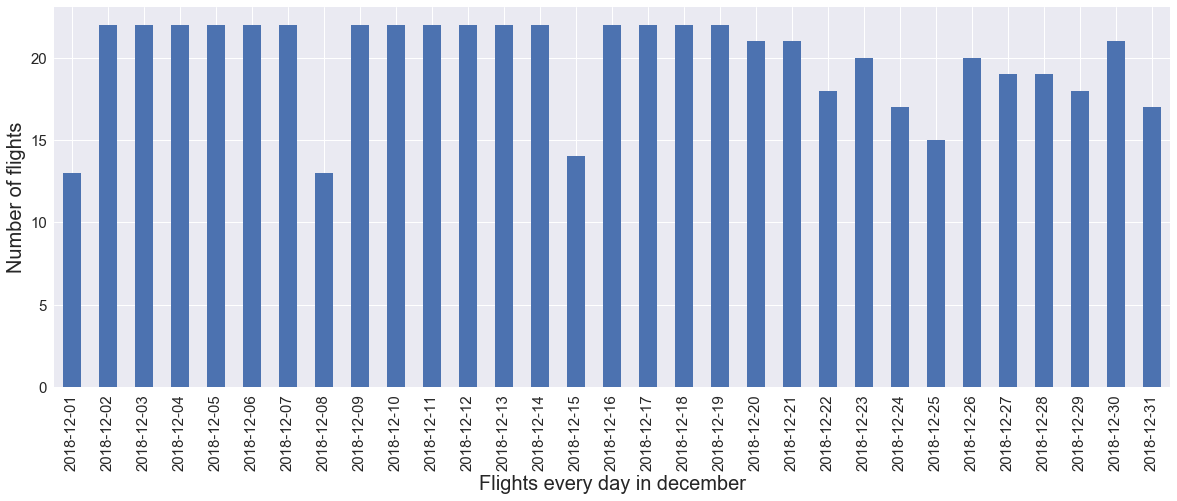

In [119]:
df_NY_SF_D = df_NY_SF.loc[df_NY_SF['MONTH'].dt.month.isin([12])]
#df_NY_SF_M = df_NY_SF_M.groupby(['DAY', 'airline_name']).count()
df_NY_SF_D['dep_delay'].groupby(df_NY_SF_D['DAY']).count().plot.bar(figsize=(20,7))
plt.xlabel("Flights every day in december", **axis_font)
plt.ylabel("Number of flights", **axis_font)
plt.show()


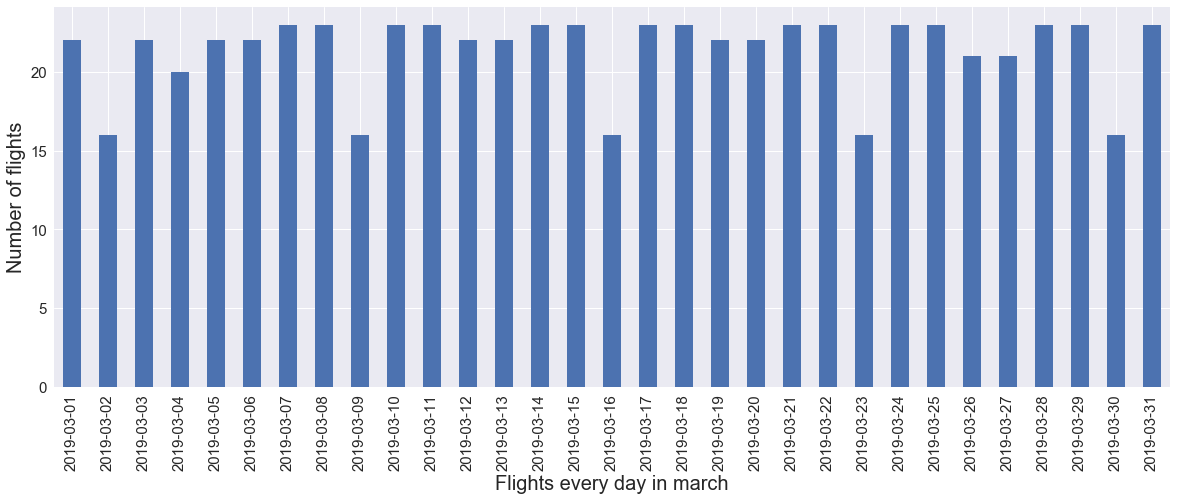

In [120]:
df_NY_SF_M = df_NY_SF.loc[df_NY_SF['MONTH'].dt.month.isin([3])]
df_NY_SF_M['dep_delay'].groupby(df_NY_SF_M['DAY']).count().plot.bar(figsize=(20,7))
plt.xlabel("Flights every day in march", **axis_font)
plt.ylabel("Number of flights", **axis_font)
plt.show()


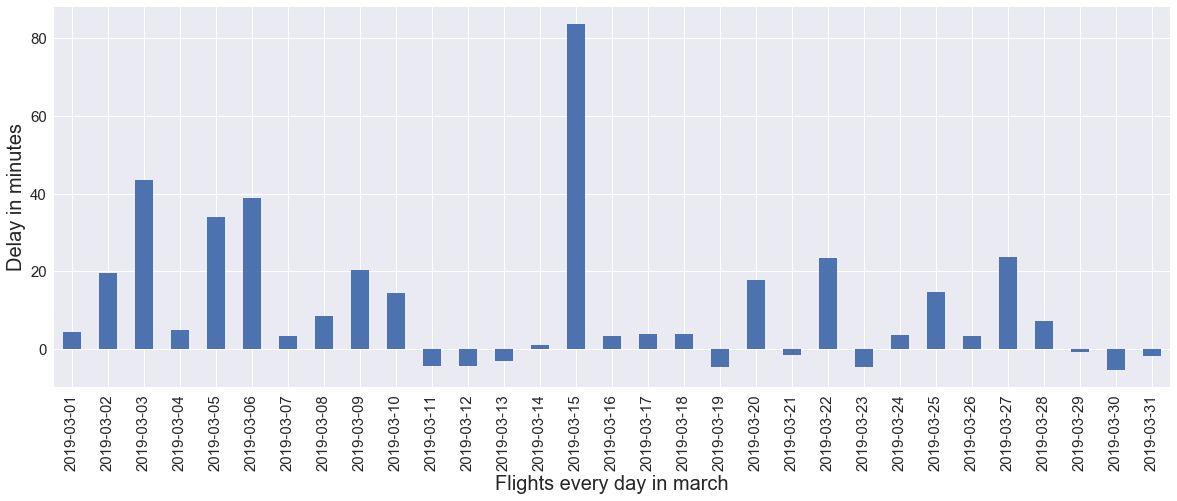

In [121]:
df_NY_SF_M = df_NY_SF.loc[df_NY_SF['MONTH'].dt.month.isin([3])]
df_NY_SF_M['dep_delay'].groupby(df_NY_SF_M['DAY']).mean().plot.bar(figsize=(20,7))
plt.xlabel("Flights every day in march", **axis_font)
plt.ylabel("Delay in minutes", **axis_font)
plt.show()


### Reviewing a regular travel month March and an irregular month December, there seems to be a consistency on this route where the number of flights drops on Saturdays, except for towards the end of Dec where we expect unusual fluctuations in flights due to the holidays. Let's take a quick look to see if this is caused by any particular airlines

In [122]:
df_NY_SF_M = df_NY_SF_M.join(df_NY_SF_M['airline_name'].str.get_dummies())
#print(df_NY_SF_M.columns)

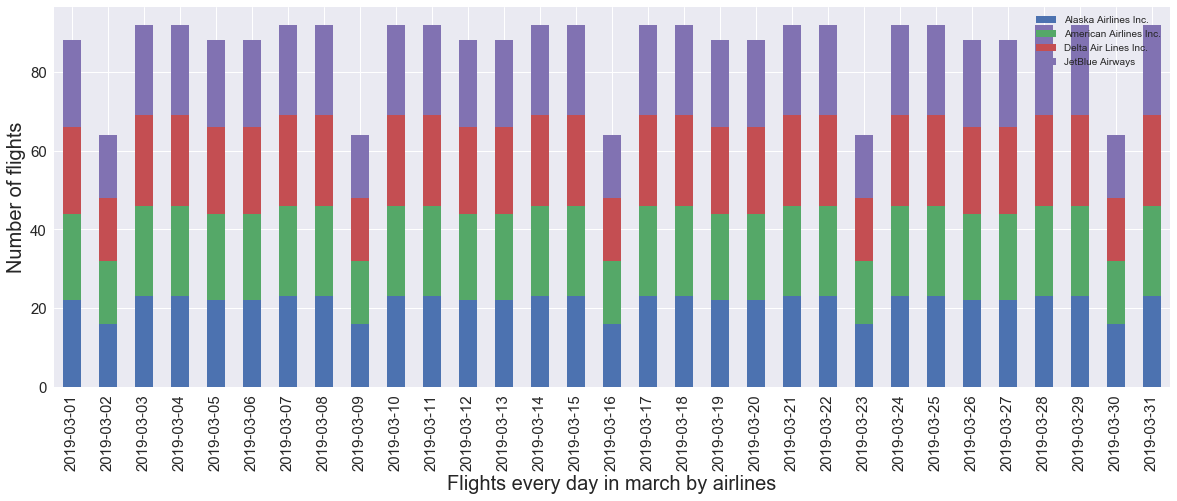

In [123]:
df_NY_SF_M.loc[:,['Alaska Airlines Inc.','American Airlines Inc.', 'Delta Air Lines Inc.', 'JetBlue Airways']].groupby(df_NY_SF_M['DAY']).count().plot.bar(stacked=True, figsize=(20,7))
plt.xlabel("Flights every day in march by airlines", **axis_font)
plt.ylabel("Number of flights", **axis_font)
plt.show()

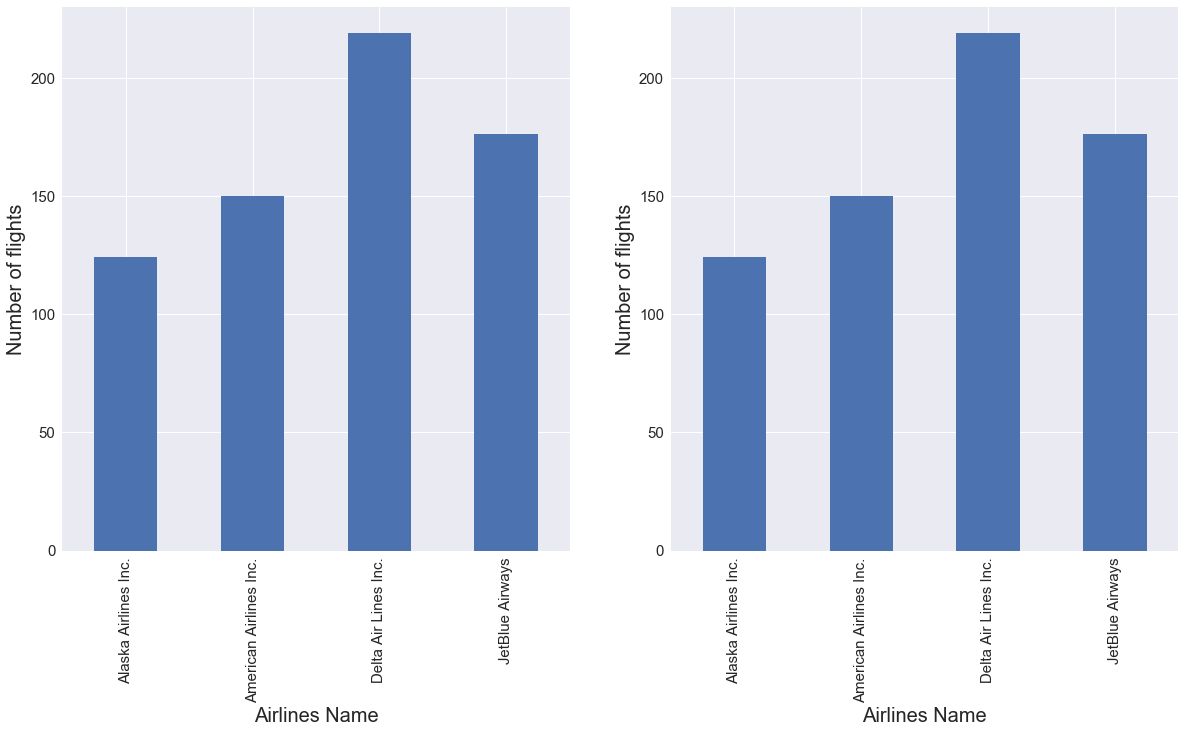

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

df_NY_SF_M['airline_name'].groupby(df_NY_SF_M['airline_name']).count().plot(kind='bar', ax=ax1)
df_NY_SF['airline_name'].groupby(df_NY_SF_M['airline_name']).count().plot(kind='bar', ax=ax2)

# adjust fonts and labels
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(15)

ax1.set_xlabel('Airlines Name', **axis_font)
ax1.set_ylabel('Number of flights', **axis_font)
ax2.set_xlabel('Airlines Name', **axis_font)
ax2.set_ylabel('Number of flights', **axis_font)

plt.show()

### Looking at both a one month view and total flights view, it looks like Delta Air Lines has the most flights on this route

## Delays

## first lets have an exploratory look at the data around delays. Some questions:
- What are average delay times?
- What are the extreme delay times?
- what factors are correlated to delays? time of day? 
- What about airlines? Is there an airlines thats most associated with delays?

In [125]:
print(df_NY_SF.columns)
print(df_nyflights.columns)

Index(['fl_date', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out',
       'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time',
       'arr_delay', 'cancelled', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'airline_name', 'MONTH',
       'DAY', 'Days_in_Month'],
      dtype='object')
Index(['fl_date', 'op_carrier_airline_id', 'op_carrier_fl_num',
       'origin_airport_id', 'origin_city_market_id', 'dest_airport_id',
       'dest_city_market_id', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance'],
      dtype='object')


In [126]:
df_NY_SF['crs_dep_time'] = df_nyflights['crs_dep_time'].astype(int)
df_NY_SF['dep_time'] = df_nyflights['dep_time'].astype(int)
df_NY_SF['crs_arr_time'] = df_nyflights['crs_arr_time'].astype(int)
df_NY_SF['arr_time'] = df_nyflights['arr_time'].astype(int)
df_NY_SF.dropna(inplace=True)
#df_NY_SF.iloc[:, [1,2,3,4,7,8,9,10,13,14,15,17]].corr()

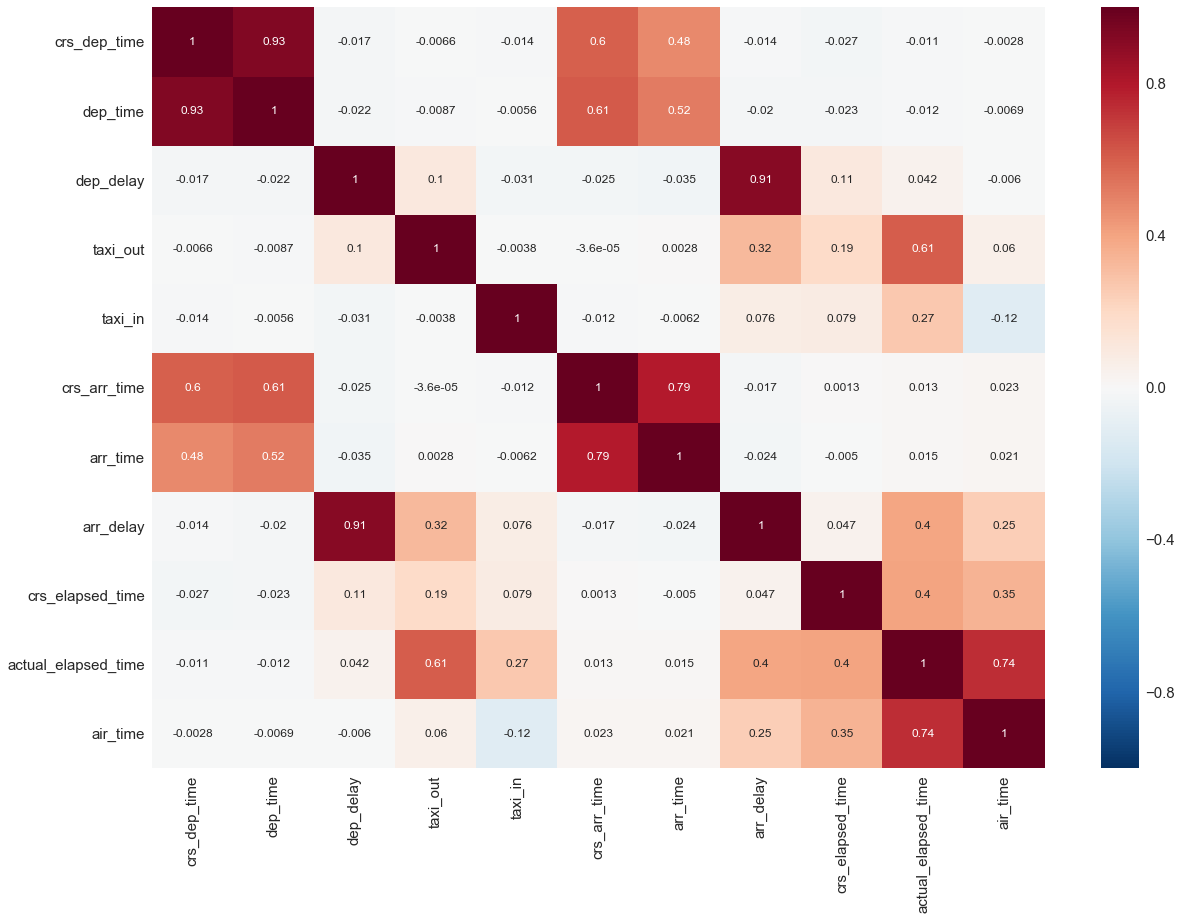

In [127]:
axis = plt.subplots(figsize=(20,14))
sns.heatmap(df_NY_SF.iloc[:, [1,2,3,4,7,8,9,10,13,14,15,17]].corr(),annot = True)
plt.show()

## Some observations from the correlation heatmap
- it is easier to estimate departure time correctly vs estimating arrive times: estimated departure time is more correlated to actual depature time at 0.92, compared with estimated arrival time and actual arrival time at 0.79
- arrival delays and departure delays are highly correlated at 0.9, meaning that if a flight takes of late, it is highly likely to arrive late
- actual flight time and time in the air are correlated at 0.74, meaning that other factors do contribute
- Surprisingly, taxi out time has a strong correlation with actual flight time at 0.6 but taxi in is much lower at 0.3, perhaps suggesting that the airport should focus on this
- flight time estimates are not good estimates of actual flight time as correlation is low at 0.39
- A hypothesis I had was maybe time of day mattered to delays (arrival / departure), but this may not be the case as the correlation is in the low negative values ~ -0.01

/Users/adelleli/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/adelleli/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


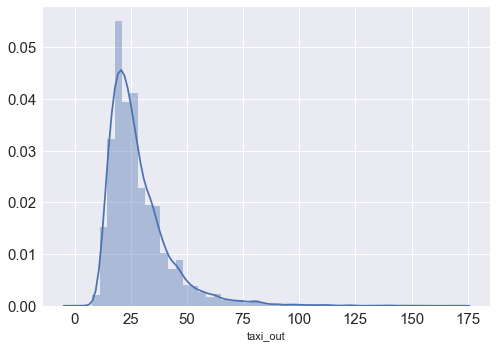

In [128]:
# To check the Distribution of taxi out time
sns.distplot(df_NY_SF['taxi_out'])
plt.show()

In [28]:
print(df_NY_SF['taxi_out'].mean())
print(df_NY_SF['taxi_out'].max())

28.545885286783044
170.0


### Flights on this route spend an average of 28 minutes in taxi out and the longest time spent on the runway is nearly 3 hours

/Users/adelleli/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/adelleli/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


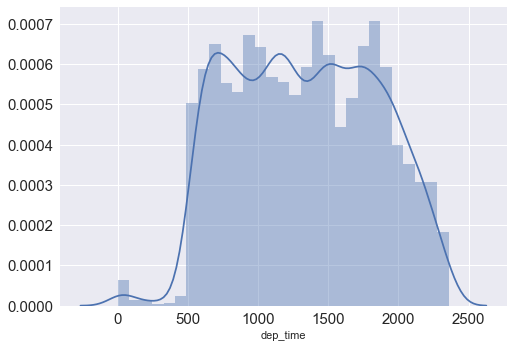

In [33]:
# To check the Distribution of departure time
sns.distplot(df_NY_SF['dep_time'])
plt.show()

/Users/adelleli/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/adelleli/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


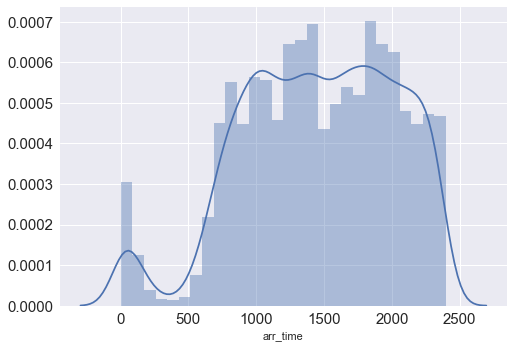

In [34]:
# To check the Distribution of arrival time
sns.distplot(df_NY_SF['arr_time'])
plt.show()

/Users/adelleli/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/adelleli/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


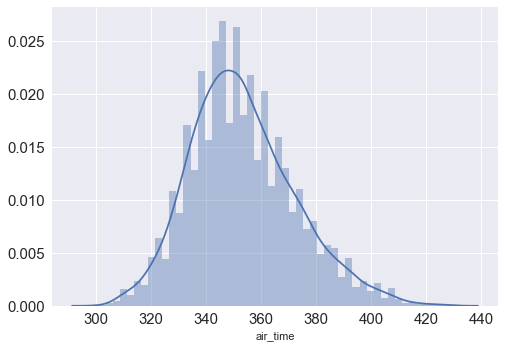

In [35]:
# To check the Distribution of Air Time
sns.distplot(df_NY_SF['air_time'])
plt.show()

/Users/adelleli/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/adelleli/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


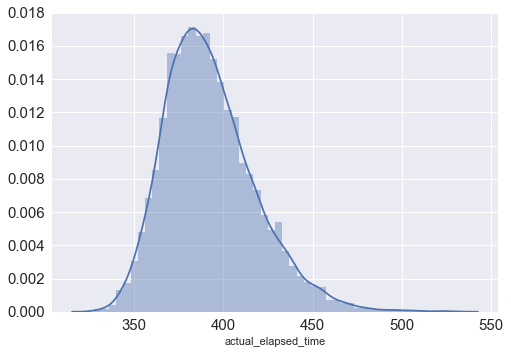

In [36]:
sns.distplot(df_NY_SF['actual_elapsed_time'])
plt.show()

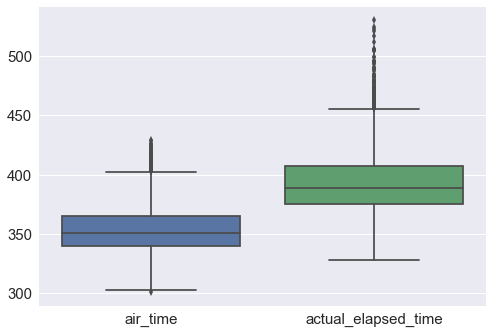

In [37]:
sns.boxplot(data=df_NY_SF[['air_time', 'actual_elapsed_time']])
plt.show()

### Lets look at some quick summary statistics given that we consider delays being delays for > 30 minutes.

In [38]:
# add a column to classify if delayed for arrival_delay or departure_delay > 30
df_NY_SF['dep_delay_class'] = df_NY_SF.dep_delay.apply(lambda x: np.where(x > 30, 1, 0))
df_NY_SF['arr_delay_class'] = df_NY_SF.arr_delay.apply(lambda x: np.where(x > 30, 1, 0))
arr_delay = df_NY_SF['dep_delay_class']==1
dep_delay = df_NY_SF['arr_delay_class']==1
percentage_flight_delay = len(df_NY_SF[dep_delay | arr_delay])/len(df_NY_SF)
percentage_flight_arr_delay = len(df_NY_SF[arr_delay])/len(df_NY_SF)
percentage_both_delay = len(df_NY_SF[arr_delay & dep_delay])/len(df_NY_SF[dep_delay])

print("Percentage of flight delays on this route is {:.2f}%".format(percentage_flight_delay))
print("Percentage of flight arrival delays on this route is {:.2f}%".format(percentage_flight_arr_delay))
print("% of flight arrival delays that were also delayed on depature is {:.2f}%".format(percentage_both_delay))


Percentage of flight delays on this route is 0.19%
Percentage of flight arrival delays on this route is 0.13%
% of flight arrival delays that were also delayed on depature is 0.68%


In [39]:
## Knowing that a flight is delayed on departure will help predict on 

## lets looks at the distribution of delay times

/Users/adelleli/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/adelleli/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


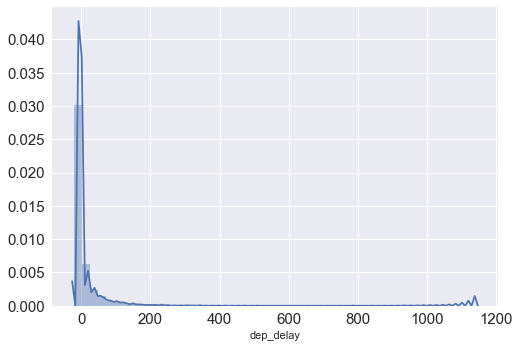

In [40]:
# To check the Distribution of Air Time
sns.distplot(df_NY_SF['dep_delay'])
plt.show()

/Users/adelleli/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/adelleli/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


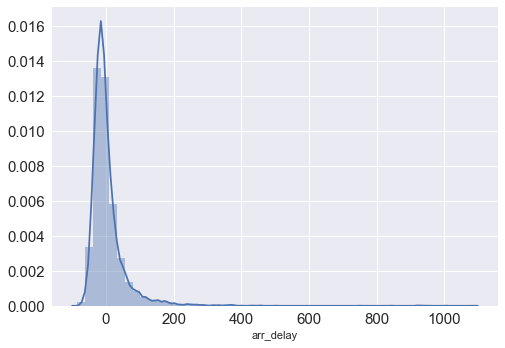

In [41]:
# To check the Distribution of Air Time
sns.distplot(df_NY_SF['arr_delay'])
plt.show()

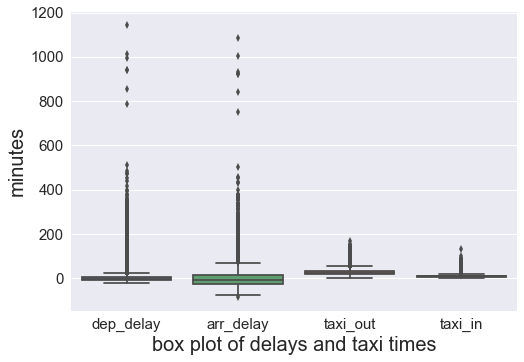

In [42]:
box = df_NY_SF.loc[:,['fl_date', 'dep_delay', 'arr_delay','taxi_out','taxi_in', 'actual_elapsed_time', 'air_time', 'distance']]
sns.boxplot(data=box[['dep_delay', 'arr_delay' ,'taxi_out','taxi_in']])
plt.xlabel('box plot of delays and taxi times', **axis_font)
plt.ylabel('minutes', **axis_font)
plt.show()

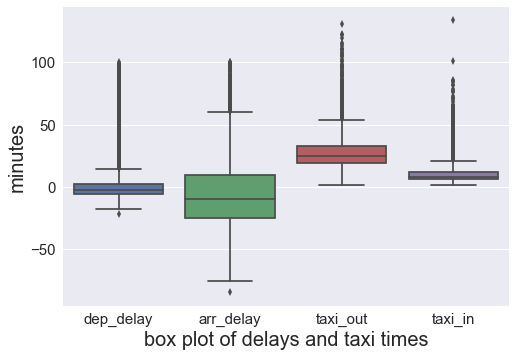

In [43]:
boxN = box.copy()
boxN = boxN.drop(boxN[boxN['dep_delay']>100].index)
boxN = boxN.drop(boxN[boxN['arr_delay']>100].index)
sns.boxplot(data=boxN[['dep_delay', 'arr_delay' ,'taxi_out','taxi_in']])
plt.xlabel('box plot of delays and taxi times', **axis_font)
plt.ylabel('minutes', **axis_font)
plt.show()

### Arrival delays have a wider distribution compared to departure delays, it is centered around negative values, meaning that many flights do arrive earlier than estimated.
### Taxi out time is typically longer than taxi in, which supports the correlation observation above

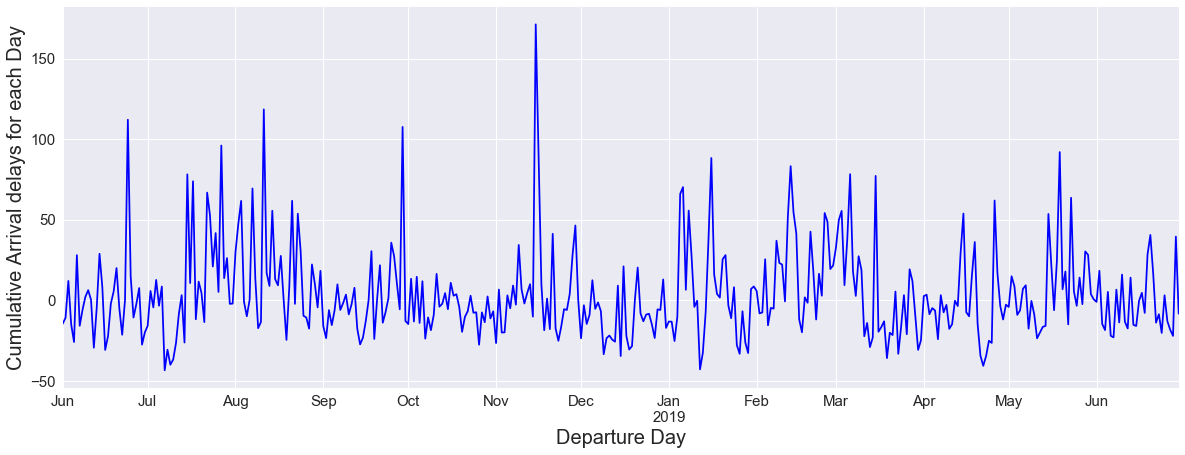

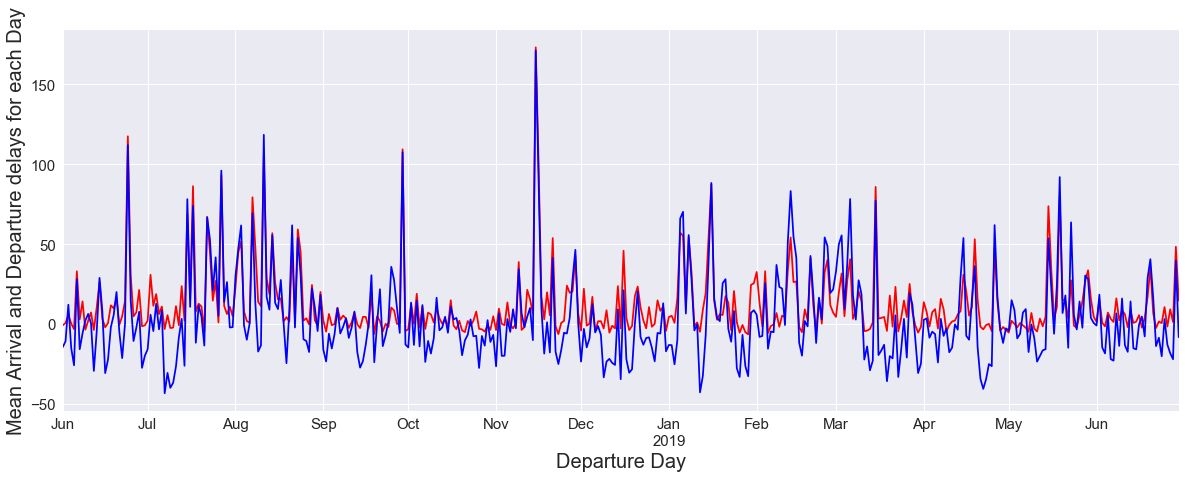

In [44]:
# lets plot the delays column
#df_NY_SF.groupby('DAY').sum()['dep_delay'].plot(kind='line', figsize=(20,7))
df_NY_SF.groupby('DAY').mean()['arr_delay'].plot(kind='line', color = 'blue', figsize=(20,7))
plt.xlabel("Departure Day", **axis_font)
plt.ylabel("Cumulative Arrival delays for each Day", **axis_font)
plt.show()
df_NY_SF.groupby('DAY').mean()['dep_delay'].plot(kind='line', color = 'red', figsize=(20,7))
df_NY_SF.groupby('DAY').mean()['arr_delay'].plot(kind='line', color = 'blue', figsize=(20,7))
plt.xlabel("Departure Day", **axis_font)
plt.ylabel("Mean Arrival and Departure delays for each Day", **axis_font)
plt.show()

In [45]:
_, bp = pd.DataFrame.boxplot(box[['dep_delay', 'arr_delay' ,'taxi_out','taxi_in']], return_type='both')

# outliers = [flier.get_ydata() for flier in bp["fliers"]]
# boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]
print("median", medians, "whiskers", whiskers)

median [array([-3., -3.]), array([-8., -8.]), array([25., 25.]), array([8., 8.])] whiskers [array([ -6., -22.]), array([ 6., 24.]), array([-24., -76.]), array([14., 71.]), array([19.,  1.]), array([34., 56.]), array([6., 1.]), array([12., 21.])]


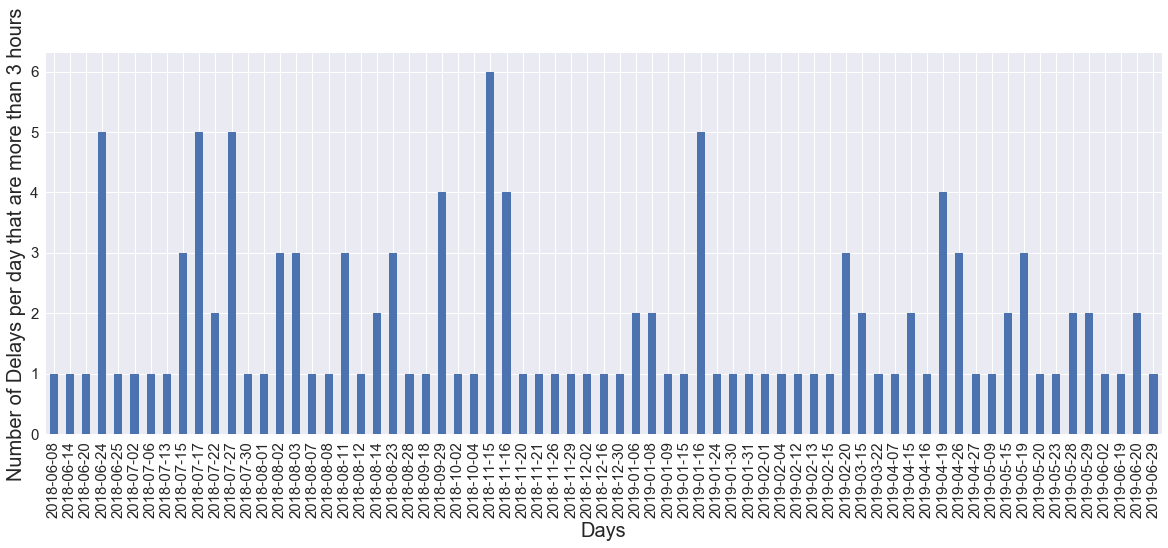

In [58]:
df_NY_SF.loc[df_NY_SF[df_NY_SF['dep_delay']>180].index,:].groupby(['DAY']).count()['dep_delay'].plot(kind='bar', figsize=(20,7))
plt.xlabel("Days", **axis_font)
plt.ylabel("Number of Delays per day that are more than 3 hours", **axis_font)
plt.show()

In [47]:
df_delay = df_NY_SF.groupby('DAY').mean()
df_delay = df_delay.sort_values(by=['dep_delay','arr_delay'], ascending=False)
df_delay.head(5)

,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,Days_in_Month,dep_delay_class,arr_delay_class
DAY,,,,,,,,,,,,,,,,,
2018-11-15,1277.500000,1194.045455,173.181818,43.136364,10.045455,1581.272727,1490.545455,171.181818,0.0,0.0,402.363636,400.363636,347.181818,2586.0,30.0,0.636364,0.545455
2018-06-24,1429.130435,1431.565217,117.521739,41.347826,10.391304,1624.695652,1621.217391,112.043478,0.0,0.0,400.652174,395.173913,343.434783,2586.0,30.0,0.391304,0.391304
2018-09-29,1732.000000,1746.466667,109.400000,28.266667,7.066667,1042.933333,1034.200000,107.600000,0.0,0.0,386.866667,385.066667,349.733333,2586.0,30.0,0.733333,0.800000
2018-08-11,1058.066667,1035.600000,106.133333,64.066667,14.800000,1156.466667,1151.733333,118.466667,0.0,0.0,391.133333,403.466667,324.600000,2586.0,31.0,0.800000,0.866667
2018-11-16,1454.409091,1518.409091,102.090909,24.818182,8.636364,1527.000000,1346.636364,91.454545,0.0,0.0,403.409091,392.772727,359.318182,2586.0,30.0,0.681818,0.590909


### A few days showed extremely long delays - 11-15 anf 11-16 in 2018, 06-24-18, 09-29-18 and 08-11-18 were the top 5 days based on mean delay time. These days roughly correlated with higher number of delays as well.

## So far, we've only been looking at delays at a whole, how about digging a little deeper into the airlines.
## Which airlines had the most delays in terms of count? Jetblue

In [48]:
#df_NY_SF['dep_delay_class'] = df_NY_SF.dep_delay.apply(lambda x: np.where(x > 30, 1, 0))
df_delays = df_NY_SF.loc[df_NY_SF['arr_delay']>30]
df_delays.groupby('airline_name').count()['arr_delay'].sort_values(ascending=False)

airline_name
JetBlue Airways           391
Delta Air Lines Inc.      374
American Airlines Inc.    310
Alaska Airlines Inc.      222
Name: arr_delay, dtype: int64

In [49]:
df_NY_SF['arr_delay_class'] = df_NY_SF['arr_delay'].apply(lambda x: np.where(x > 30, 1, 0))
df_NY_SF.groupby('airline_name').sum()['arr_delay_class'].sort_values(ascending=False)

airline_name
JetBlue Airways           391
Delta Air Lines Inc.      374
American Airlines Inc.    310
Alaska Airlines Inc.      222
Name: arr_delay_class, dtype: int64

## Which airline has the highest chance of delay on arrival? American Airlines, although Jetblue is pretty close

In [50]:
df_NY_SF.groupby('airline_name').mean()['arr_delay_class'].sort_values(ascending=False)

airline_name
American Airlines Inc.    0.178777
JetBlue Airways           0.178620
Alaska Airlines Inc.      0.149394
Delta Air Lines Inc.      0.143240
Name: arr_delay_class, dtype: float64

In [51]:
### NOTES: Another way to hand calculate probability of delay
df_AA = df_NY_SF[df_NY_SF['airline_name']=='American Airlines Inc.']
#boxN.drop(boxN[boxN['dep_delay']>100].index)
df_A_delayed = df_AA[df_AA['arr_delay_class']==1]
print(len(df_A_delayed)/len(df_AA))

0.1787773933102653


## Which airlines had the most extreme delays? If we take into account negative delays compensating for positive delays, then it is Jetblue. However if we just look at delays that are larger than 30 minutes then it is Delta


In [52]:
df_NY_SF.groupby('airline_name').sum()['arr_delay'].sort_values(ascending=False)

airline_name
JetBlue Airways           13487.0
American Airlines Inc.    10027.0
Delta Air Lines Inc.       6598.0
Alaska Airlines Inc.       1881.0
Name: arr_delay, dtype: float64

In [53]:
df_delays.groupby('airline_name').sum()['arr_delay'].sort_values(ascending=False)

airline_name
Delta Air Lines Inc.      37746.0
JetBlue Airways           37331.0
American Airlines Inc.    25871.0
Alaska Airlines Inc.      18006.0
Name: arr_delay, dtype: float64

## Which airlines has the highest average delays? Delta airlines (removing delays that are less than 30 minutes in the dataset)

In [54]:
df_NY_SF.groupby('airline_name').mean()['arr_delay'].sort_values(ascending=False)


airline_name
JetBlue Airways           6.161261
American Airlines Inc.    5.782584
Delta Air Lines Inc.      2.527001
Alaska Airlines Inc.      1.265814
Name: arr_delay, dtype: float64

In [55]:
df_delays.groupby('airline_name').mean()['arr_delay'].sort_values(ascending=False)

airline_name
Delta Air Lines Inc.      100.925134
JetBlue Airways            95.475703
American Airlines Inc.     83.454839
Alaska Airlines Inc.       81.108108
Name: arr_delay, dtype: float64

In [56]:
df_delay_airlines = df_NY_SF.groupby(['DAY', 'airline_name']).sum()
df_delay_airlines = df_delay_airlines.sort_values(by=['dep_delay','arr_delay'], ascending=False)
df_delay_airlines.head(5)

,,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,Days_in_Month,dep_delay_class,arr_delay_class
DAY,airline_name,,,,,,,,,,,,,,,,,
2018-06-24,Delta Air Lines Inc.,11744.0,11890.0,1930.0,242.0,74.0,13387.0,13382.0,1649.0,0,0,3306.0,3025.0,2709.0,20688.0,240,4,3
2018-11-15,Delta Air Lines Inc.,10163.0,10270.0,1653.0,332.0,107.0,12571.0,12605.0,1615.0,0,0,3240.0,3202.0,2763.0,20688.0,240,6,4
2018-11-16,Delta Air Lines Inc.,9775.0,10049.0,1522.0,162.0,60.0,9916.0,7636.0,1386.0,0,0,2851.0,2715.0,2493.0,18102.0,210,7,6
2018-11-15,American Airlines Inc.,5159.0,5142.0,1181.0,157.0,20.0,6104.0,6035.0,1172.0,0,0,1611.0,1602.0,1425.0,10344.0,120,3,3
2019-05-19,Delta Air Lines Inc.,10931.0,11237.0,1090.0,375.0,184.0,13672.0,13762.0,1215.0,0,0,3232.0,3357.0,2798.0,20688.0,248,4,5


### By ranking the airlines based on most extreme delays by day, Delta airlines is responsible for 4 of the 5 most extreme delays on this route in the dataset provided

340.0
325.3599999999997
25.0


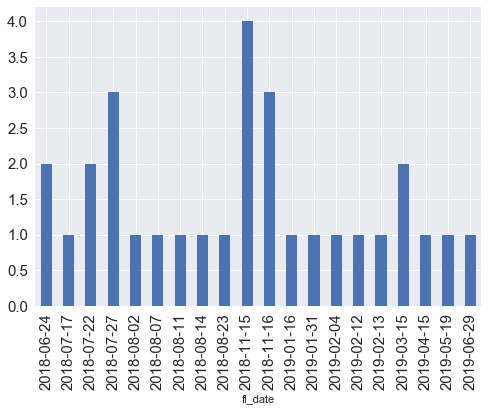

0.003740648379052369
8020


In [60]:
print(df_NY_SF.loc[df_NY_SF[df_NY_SF['dep_delay']>0].index,:]['dep_delay'].quantile(0.99))
print(df_NY_SF.loc[df_NY_SF[df_NY_SF['arr_delay']>0].index,:]['arr_delay'].quantile(0.99))
print(df_NY_SF.loc[df_NY_SF[df_NY_SF['arr_delay']>0].index,:]['arr_delay'].quantile(0.50))

df_95 = df_NY_SF.loc[df_NY_SF[df_NY_SF['arr_delay']>325].index,['fl_date','dep_delay','arr_delay', 'airline_name']]
df_95.groupby('fl_date').count()['dep_delay'].plot(kind='bar')
plt.show()
print(len(df_95)/len(df_NY_SF))
print(len(df_NY_SF))

### Part 2: Comparing airports

Create some summary data and visualizations comparing the three NYC-area airports. Of particular interest are departure delays from the airports. Are there differences in the probability of a late (say, more than 30 min.) departure? How does time spent on the runway compare amongst the airports?

In [62]:
query = '''SELECT ny_flights.*, airports.airport_name from ny_flights 
    JOIN airports
    ON ny_flights.origin_airport_id = airports.id
    WHERE origin_airport_id=12478 OR origin_airport_id=12953 OR origin_airport_id=11618'''

df_NY = pd.read_sql_query(query, conn)

df_NY = df_NY.loc[:,['fl_date', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'airport_name']]
df_NY.tail(5)

,fl_date,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,airport_name
330871,2019-06-30,1045,1041,-4.0,14.0,1055,1204,6.0,1245,1210,-35.0,0,0,120.0,89.0,69.0,461.0,LaGuardia
330872,2019-06-30,0830,0932,62.0,14.0,0946,1108,4.0,1046,1112,26.0,0,0,136.0,100.0,82.0,544.0,LaGuardia
330873,2019-06-30,1400,1545,105.0,49.0,1634,1732,12.0,1544,1744,120.0,0,0,164.0,179.0,118.0,733.0,LaGuardia
330874,2019-06-30,1700,1849,109.0,39.0,1928,2019,4.0,1859,2023,84.0,0,0,179.0,154.0,111.0,733.0,LaGuardia
330875,2019-06-30,1630,1837,127.0,54.0,1931,2022,10.0,1825,2032,127.0,0,0,175.0,175.0,111.0,733.0,LaGuardia


## Cleaning: looks like a lof of the nan values are recorded in relation to arrival times when flights are cancelled or diverted. Althrough cancellations are considered a type of delay, for the purpose of simplification, we'll remove all nan values.

In [63]:
df_NY= df_NY.dropna()

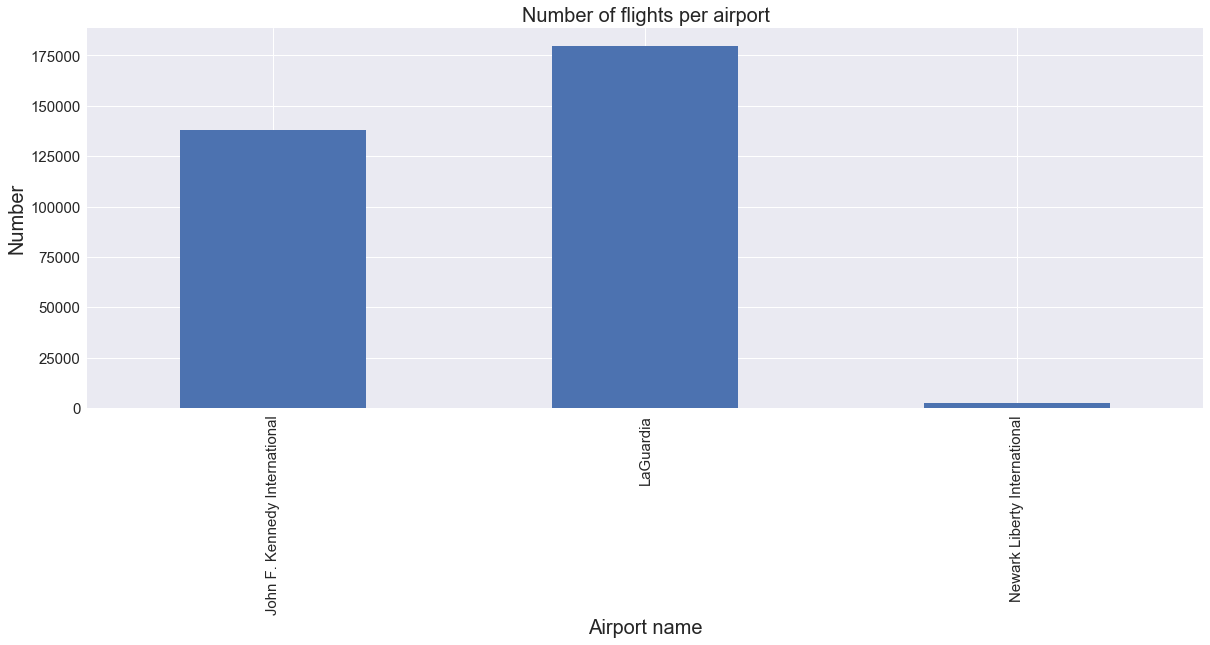

In [64]:
df_NY.groupby('airport_name')['wheels_off'].count().plot(kind='bar', figsize = (20,7))

plt.ylabel('Number', **axis_font)
plt.xlabel('Airport name', **axis_font)
plt.title('Number of flights per airport', **axis_font)
plt.show()

### Which airport has the highest probability of departure delay? Newark Liberty International despite the least number of flights leaving

In [65]:
# given a late departure is more than 30 minutes
df_NY['late_dep_class'] = df_NY['arr_delay'].apply(lambda x: np.where(x>30, 1, 0))
df_NY.groupby('airport_name')["late_dep_class"].mean()

airport_name
John F. Kennedy International    0.139422
LaGuardia                        0.169734
Newark Liberty International     0.226816
Name: late_dep_class, dtype: float64

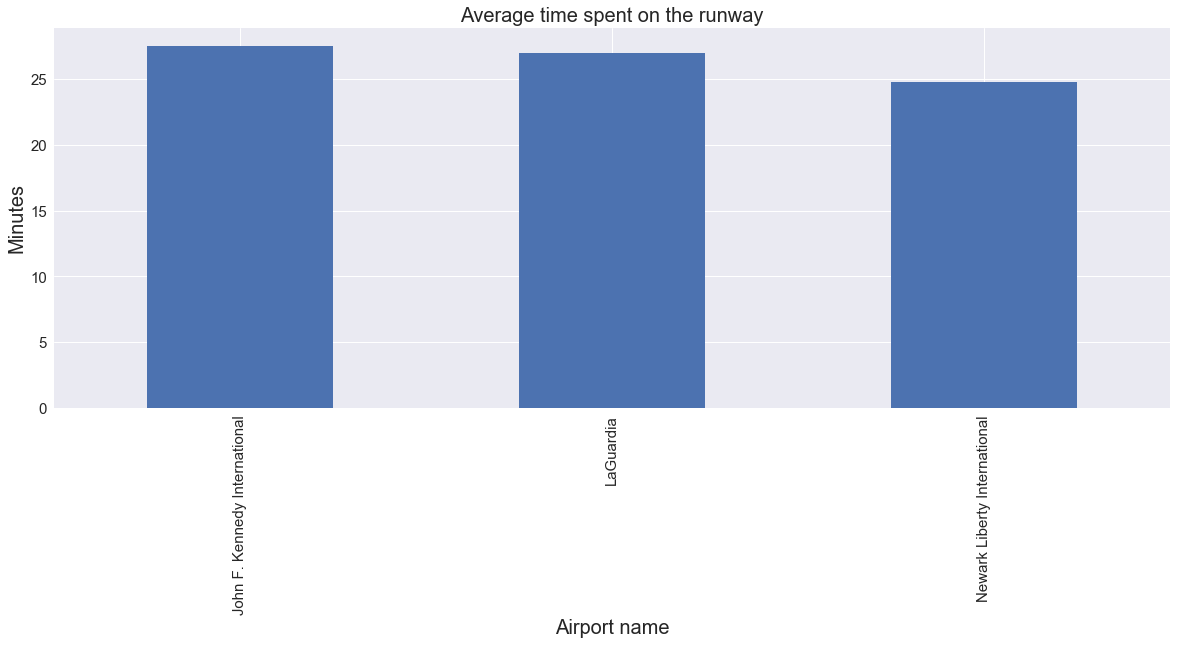

27.529695302887745
24.801862197392925


In [69]:
df_NY.groupby('airport_name')['taxi_out'].mean().plot(kind='bar', figsize=(20,7))
plt.ylabel('Minutes', **axis_font)
plt.xlabel('Airport name', **axis_font)
plt.title('Average time spent on the runway', **axis_font)
plt.show()
print(df_NY.groupby('airport_name')['taxi_out'].mean().max())
print(df_NY.groupby('airport_name')['taxi_out'].mean().min())

### The average time flights spend on the runway is 24.8 minutes (shortest) at Newark and 27.5 minutes at JKF (longest)

### Part 3: Modeling delays

1. Build a simple model that estimates the probability that a given flight will have a late (greater than 30 min.) departure or arrival.

	- You can interpret the term "model" loosely: Any method that, given some inputs known prior to a flight, will produce an estimated probability that the flight will be delayed or arrive late. You should also be able to use the model to show the uncertainty around the estimate.

2. Discuss the results of your fitted model. Here are a few things to describe:

	- The performance of your model---either its in-sample fit, or out-of-sample prediction accuracy (or both).
	- For a few interesting example flights or routes, use the model to estimate probability of a late departure or arrival and its uncertainty. Describe the results in plain English.
	- If your model is suited to estimating factors that affect delays (that is, it has interpretable coefficients), describe the estimated effects.

3. Describe anything you feel might be missing from your model, or alternative approaches you might try with more time or data. If you think additional data would be helpful, describe what you would want.

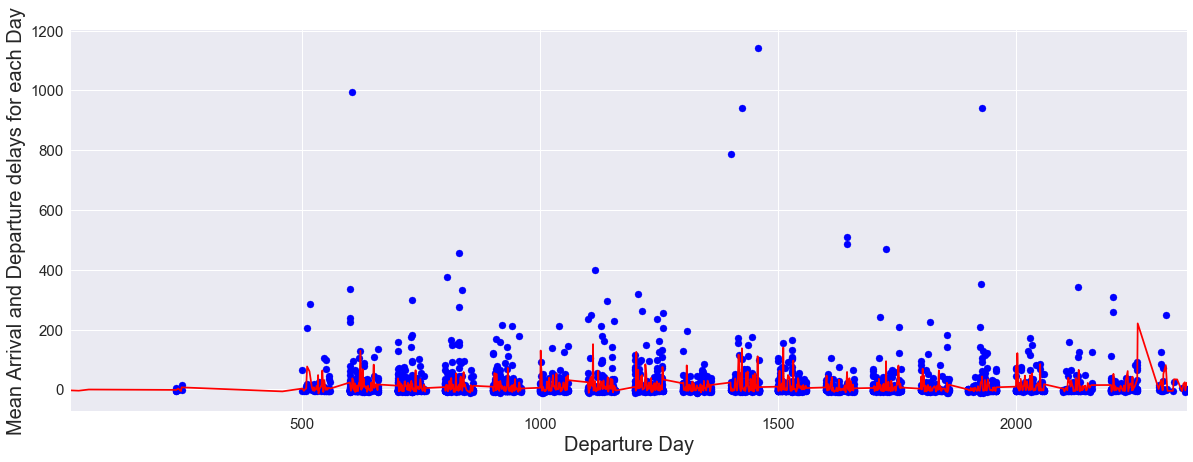

In [80]:
x = df_NY_SF[df_NY_SF['airline_name']=='Delta Air Lines Inc.']['crs_dep_time']
y = df_NY_SF[df_NY_SF['airline_name']=='Delta Air Lines Inc.']['dep_delay']
plt.figure(figsize=(20,7))
plt.scatter(x, y, color='blue')  
df_NY_SF.groupby('crs_dep_time').mean()['dep_delay'].plot(kind='line', color = 'red', figsize=(20,7))
plt.xlabel("Departure Day", **axis_font)
plt.ylabel("Mean Arrival and Departure delays for each Day", **axis_font)
plt.show()

In [87]:
from scipy.optimize import curve_fit

In [89]:
df2 = df_NY_SF[df_NY_SF['airline_name']=='Delta Air Lines Inc.']
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['crs_dep_time']#.apply(lambda x:x.time())
test2 = df2['dep_delay'].groupby(df2['crs_dep_time']).mean().reset_index()#.apply(get_stats).unstack()

#fct = lambda x:x.hour*3600+x.minute*60+x.second
print(test2.head(5))
x_val = test2['crs_dep_time']
y_val = test2['dep_delay']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

   crs_dep_time  dep_delay
0         235.0       -2.0
1         239.0       -1.0
2         246.0        6.5
3         500.0       29.5
4         503.0       -5.0


/Users/adelleli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


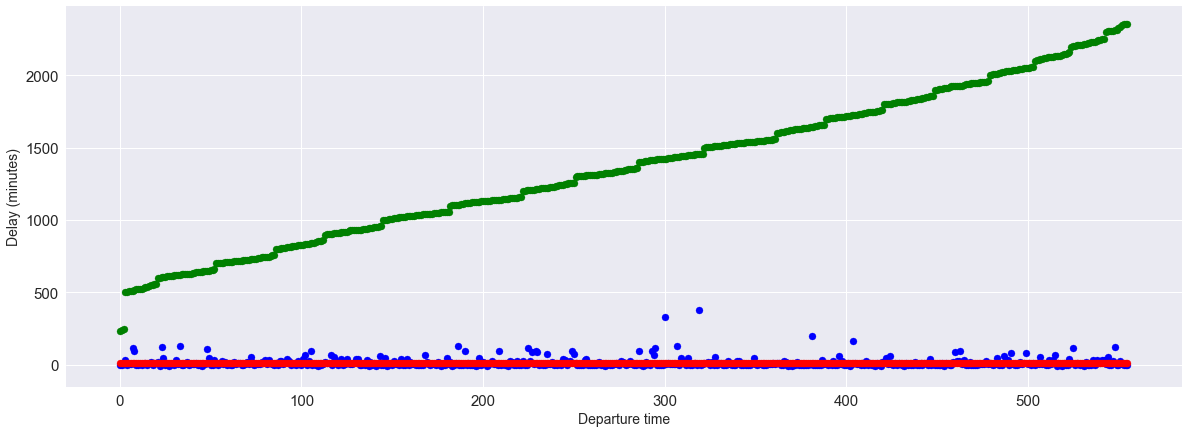

In [99]:
plt.figure(figsize=(20,7))
plt.scatter(test2.index, test2['crs_dep_time'],  color='g')
plt.scatter(test2.index, test2['dep_delay'],  color='b')
plt.scatter(test2.index, test2['fit'], color='r', linestyle='-', label='fit')

plt.ylabel('Delay (minutes)', fontsize = 14)
plt.xlabel('Departure time', fontsize = 14)
plt.show()
#fig1.set_ylim(-15, 210)

In [130]:
## lets look at 3 weeks in march
len(df_NY_SF_M).groupby

669

### Going to use all outbound flights from JFK only

In [73]:
query = '''SELECT ny_flights.*, airlines.airline_name, airports.location from ny_flights 
    JOIN airlines
    ON ny_flights.op_carrier_airline_id = airlines.id
    JOIN airports
    ON ny_flights.dest_airport_id = airports.id
    WHERE origin_airport_id=12478'''

df_JFK = pd.read_sql_query(query, conn)

df_JFK.head(5)

,fl_date,op_carrier_airline_id,op_carrier_fl_num,origin_airport_id,origin_city_market_id,dest_airport_id,dest_city_market_id,crs_dep_time,dep_time,dep_delay,...,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,airline_name,location
0,2018-06-11,20363.0,5217.0,12478.0,31703.0,12339.0,32337.0,1536,1534,-2.0,...,1759,-23.0,0,0,166.0,145.0,104.0,665.0,Endeavor Air Inc.,"Indianapolis, IN"
1,2018-06-18,20363.0,5217.0,12478.0,31703.0,12339.0,32337.0,1536,1534,-2.0,...,1756,-26.0,0,0,166.0,142.0,90.0,665.0,Endeavor Air Inc.,"Indianapolis, IN"
2,2018-06-25,20363.0,5217.0,12478.0,31703.0,12339.0,32337.0,1536,1531,-5.0,...,1759,-23.0,0,0,166.0,148.0,95.0,665.0,Endeavor Air Inc.,"Indianapolis, IN"
3,2018-06-11,20363.0,5218.0,12478.0,31703.0,10693.0,30693.0,1455,1452,-3.0,...,1702,20.0,0,0,167.0,190.0,102.0,765.0,Endeavor Air Inc.,"Nashville, TN"
4,2018-06-18,20363.0,5218.0,12478.0,31703.0,10693.0,30693.0,1455,1500,5.0,...,1626,-16.0,0,0,167.0,146.0,108.0,765.0,Endeavor Air Inc.,"Nashville, TN"


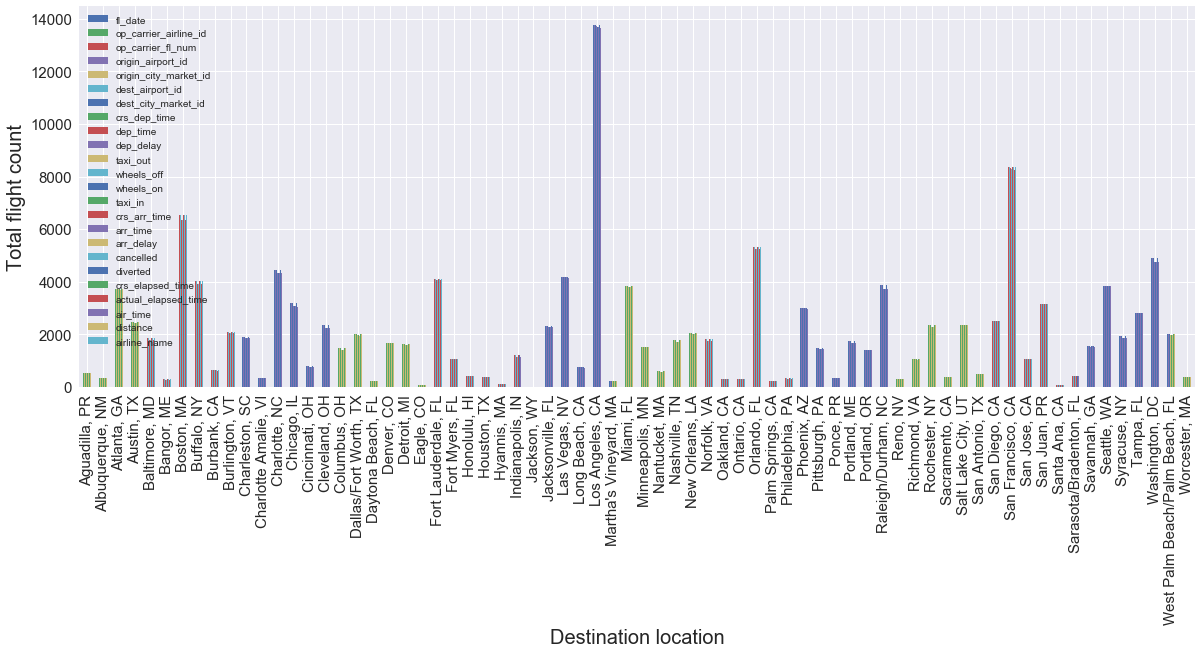

In [11]:
df_JFK.groupby('location').count().plot(kind='bar', figsize=(20,7))
plt.xlabel('Destination location', **axis_font)
plt.ylabel('Total flight count', **axis_font)
plt.show()

### looks at the empty values, consider cancellation as a delay
- remove market city data as destination location captures that more granularly
- remove estaimted arrival time and actual arrival time as that isn't data that we have before a flight
- lets combine arrival, depature delays with cancellation as our labels
- we might create a column that captures previous delay states
- maybe we'll remove cities with flight counts that are low

In [12]:
for i,e in enumerate(df_JFK.columns):
    print(i,e)

0 fl_date
1 op_carrier_airline_id
2 op_carrier_fl_num
3 origin_airport_id
4 origin_city_market_id
5 dest_airport_id
6 dest_city_market_id
7 crs_dep_time
8 dep_time
9 dep_delay
10 taxi_out
11 wheels_off
12 wheels_on
13 taxi_in
14 crs_arr_time
15 arr_time
16 arr_delay
17 cancelled
18 diverted
19 crs_elapsed_time
20 actual_elapsed_time
21 air_time
22 distance
23 airline_name
24 location


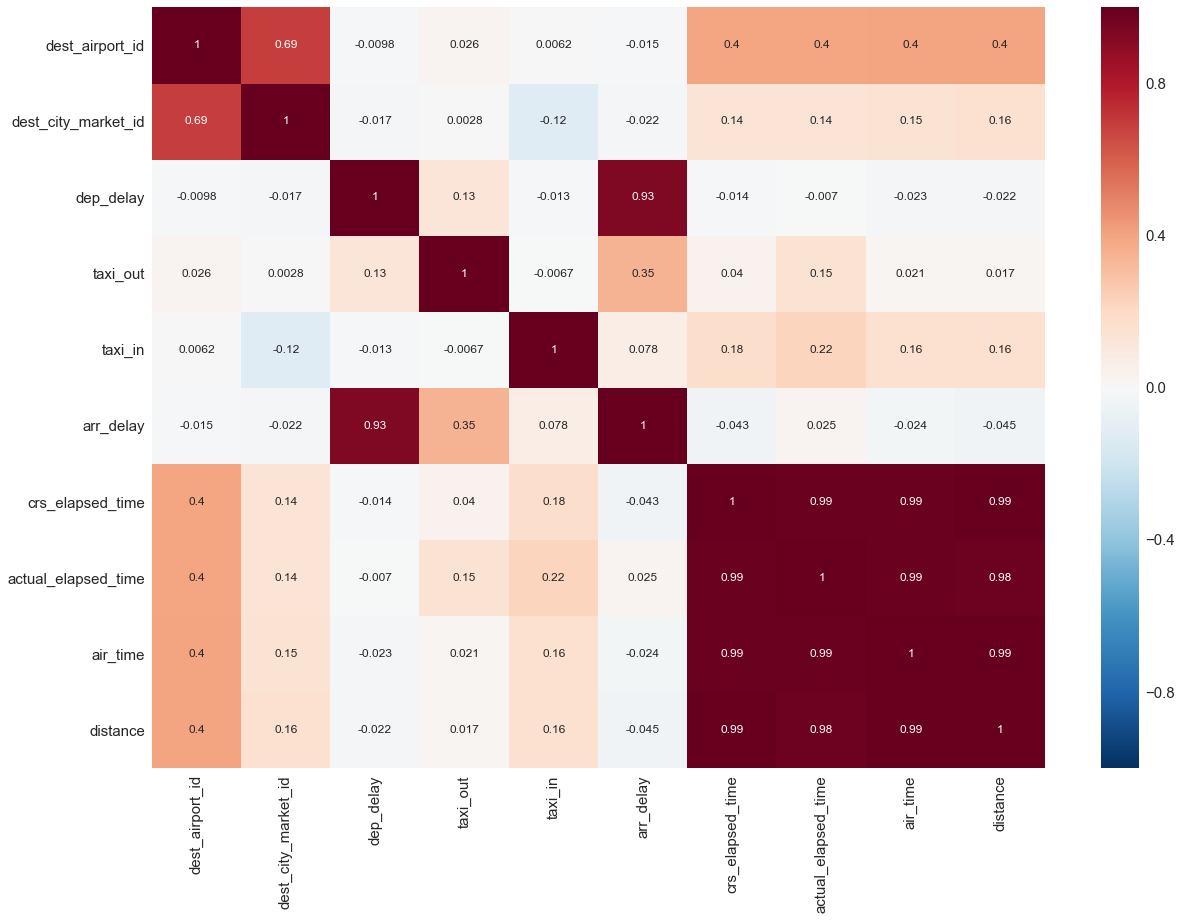

In [19]:
axis = plt.subplots(figsize=(20,14))
sns.heatmap(df_JFK.iloc[:,[5,6,7,8,9,10,13,14,15,16,19,20,21,22,23,24]].corr(),annot = True)
plt.show()


<Figure size 1440x504 with 0 Axes>

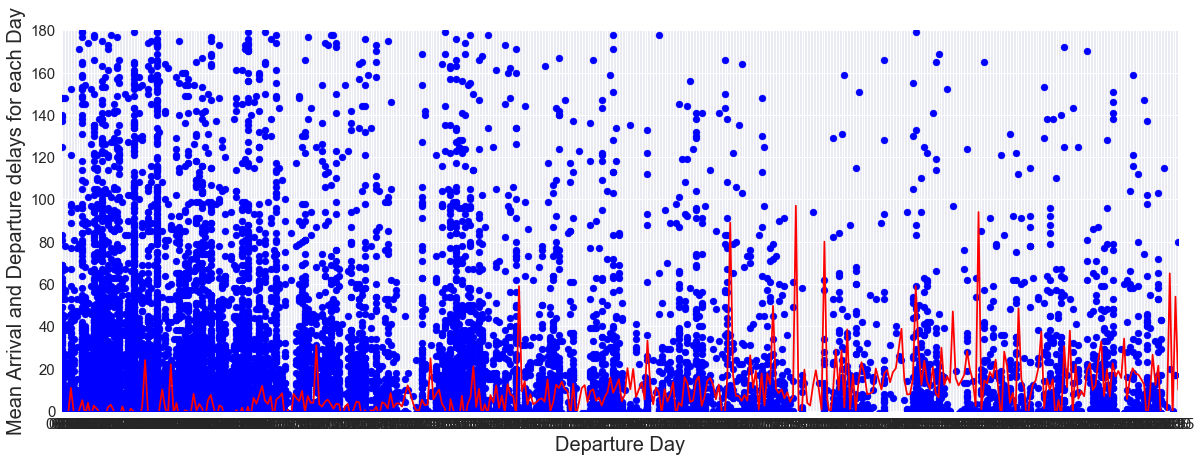

In [43]:
delta = df_JFK['airline_name']=='Delta Air Lines Inc.'
delay = df_JFK['dep_delay']<180
plt.figure(figsize=(20,7))
x = df_JFK[delta & delay]['crs_dep_time']
y = df_JFK[delta & delay]['dep_delay']
plt.figure(figsize=(20,7))
plt.scatter(x, y, color='blue')  
df_JFK[delta & delay].groupby('crs_dep_time').mean()['dep_delay'].plot(kind='line', color = 'red', figsize=(20,7))
plt.xlabel("Departure Day", **axis_font)
plt.ylabel("Mean Arrival and Departure delays for each Day", **axis_font)
plt.ylim(0,180)
plt.show()

In [ ]:
delta = df_JFK['airline_name']=='Delta Air Lines Inc.'
delay = df_JFK['dep_delay']>
plt.figure(figsize=(20,7))
x = df_JFK[delta & delay]['crs_dep_time']
y = df_JFK[delta & delay]['dep_delay']
plt.figure(figsize=(20,7))
plt.scatter(x, y, color='blue')  
df_JFK[delta & delay].groupby('crs_dep_time').mean()['dep_delay'].plot(kind='line', color = 'red', figsize=(20,7))
plt.xlabel("Departure Day", **axis_font)
plt.ylabel("Mean Arrival and Departure delays for each Day", **axis_font)
plt.ylim(0,180)
plt.show()

###  Defining delay in our data + data cleaning
Since we're looking to predict both arrival departure delays, I'll combine them into a binary category on delay vs no delay, based on the condition that later than 30 minutes is considered a delay. There is also a question about what to do with cancelled and diverted flights. For now, lets consider cancelled flights as a delay and treat diverted flights as per a regular flight, using the delay time as a label if there is one. We can definitely dig into this more based on various ramifications such as was it diverted to another airport in the same city, vs a totally different city and so passanger would need to get another connecting flight. But we'll ignore that for the purposes of this simple model.
- We'll then remove the columns containing arrival, departure delay times, cancelled and diverted labels
- Lets also remove actual departure, arrival, wheels on, wheels off and other information that we'd only get after the flight has left

In [74]:
dep = df_JFK['dep_delay']>30.
arr = df_JFK['arr_delay']>30. 
can = df_JFK['cancelled']==1
df_JFK['delay_class'] = np.where(dep | arr | can, 1, 0)
#df_JFK[['dep_delay','arr_delay','cancelled','delay_class']].tail(20)

In [75]:
df_JFK.drop(['dep_delay','arr_delay','cancelled', 'diverted', 'taxi_out', 'taxi_in', 'air_time', 'actual_elapsed_time', 'wheels_off', 'wheels_on', 'dep_time', 'arr_time'], axis=1, inplace=True)

In [76]:
missing_JFK_df = df_JFK.isnull().sum(axis=0).reset_index()
missing_JFK_df

,index,0
0,fl_date,0
1,op_carrier_airline_id,0
2,op_carrier_fl_num,0
3,origin_airport_id,0
4,origin_city_market_id,0
5,dest_airport_id,0
6,dest_city_market_id,0
7,crs_dep_time,0
8,crs_arr_time,0
9,crs_elapsed_time,0


### Converting Categorical values
Within the data that is left, I want to convert some categorical data like airlines, destination location to one hot encoding. I'll use the labelBinarizer form sklearn as that doesn't require the data to already be numerical. 

Further looking at the categories, I can remove origin airport id as there is only one origin, destination airport id as that's the same as location, as well as origin and destination city ids, since this information is inherent in the location information.

I am considering whether to quantize the estimated departure times to the top of the hour and then one hot encode it, but for a first pass I'll normalize the values.